# HST's Tranisting Exoplanet Noise Simulator  (TExoNS)

This file demonstrates how to use TExoNS to predict the:
    1. Transmission/emission spectrum S/N ratio
    2. Observation start window
for any system observed with WFC3/IR.

#### Background information
    Pandeia: ETC for JWST
    PandExo: Exoplanet noise simulator for JWST

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import os, sys
sys.path.append('..')
import pandexo.engine.justdoit as jdi
import pandexo.engine.HST_TExoNS as hst

## Edit Inputs

### Load in a blank exoplanet dictionary 

In [3]:
exo_dict = jdi.load_exo_dict()
jdi.load_exo_dict()

Replace all inputs before feeding to run_modes:
Replace all inputs before feeding to run_modes:


{'observation': {'fraction': 'time in/out',
  'noccultations': 'num transits',
  'noise_floor': 'constant number or file name',
  'sat_level': 'in % sat level',
  'transit_duration': 'in seconds',
  'wave_bin': 'in micron'},
 'planet': {'exopath': 'file path',
  'f_unit': 'rp/r* or fp/f*',
  'type': 'user',
  'w_unit': 'Angs,cm,um,cm or Hz'},
 'star': {'f_unit': 'W/m2/um, FLAM, Jy, or erg/s/cm2/Hz',
  'logg': 'cgs',
  'mag': 'magnitude',
  'metal': 'in log Fe/H',
  'ref_wave': 'corresponding ref wave',
  'starpath': 'file path',
  'temp': 'Only if phoenix, (in K)',
  'type': 'user or phoenix',
  'w_unit': 'Angs,cm,um,cm or Hz'}}

#### Edit stellar and planet inputs

In [4]:
#WASP-43
exo_dict['star']['type']      = 'phoenix'           # phoenix or user (if you have your own)
exo_dict['star']['hmag']      = 9.397               # magnitude of the system
exo_dict['star']['ref_wave']  = 1.25                # always add this in micron
exo_dict['star']['temp']      = 4400                # in K 
exo_dict['star']['metal']     = -0.05               # log Fe/H
exo_dict['star']['logg']      = 4.646               # log surface gravity cgs
#WASP-43b
exo_dict['planet']['type']    = 'user'               # user specified inputs
exo_dict['planet']['exopath'] = 'notebooks/WASP43b-Eclipse_Spectrum.txt' # filename for model spectrum
exo_dict['planet']['w_unit']  = 'um'                 # wavelength unit
exo_dict['planet']['f_unit']  = 'fp/f*'              # flux ratio unit
exo_dict['planet']['depth']   = 4.0e-3               # flux ratio
exo_dict['planet']['i']       = 82.6                 # Orbital inclination in degrees
exo_dict['planet']['ars']     = 5.13                 # Semi-major axis / stellar radius
exo_dict['planet']['period']  = 0.8135               # Orbital period in days   

### Step 2) Load in instrument dictionary
 
- NIRCam F444W
- NIRSpec Prism
- NIRSpec G395M
- NIRSpec G395H
- NIRSpec G235H
- NIRSpec G235M
- NIRCam F322W
- NIRSpec G140M
- NIRSpec G140H
- MIRI LRS
- NIRISS SOSS_Or1
- NIRISS SOSS_Or2
- WFC3 G141
- WFC3 G102

In [5]:
inst_dict = jdi.load_mode_dict('WFC3 G141')

#### Edit HST/WFC3 detector and observation inputs

In [6]:
exo_dict['calculation'] = 'scale'
inst_dict['configuration']['detector']['subarray']     = 'GRISM256'   # GRISM256 or GRISM512
inst_dict['configuration']['detector']['nsamp']        = 10           # WFC3 N_SAMP, 1..15
inst_dict['configuration']['detector']['samp_seq']     = 'SPARS5'     # WFC3 SAMP_SEQ, SPARS5 or SPARS10
exo_dict['planet']['transit_duration']            = 4170         # Transit duration in seconds
exo_dict['observation']['norbits']                     = 4            # Number of HST orbits
exo_dict['observation']['noccultations']               = 5            # Number of transits/eclipses
exo_dict['observation']['nchan']                       = 15           # Number of spectrophotometric channels
exo_dict['observation']['scanDirection']               = 'Forward'    # Spatial scan direction, Forward or Round Trip

## Run PandExo

`    jdi.run_pandexo(exo, inst, param_space = 0, param_range = 0,save_file = True,
                            output_path=os.getcwd(), output_file = '')`

See wiki Attributes for more thorough explanation fo inputs


In [7]:
foo = jdi.run_pandexo(exo_dict, inst_dict, output_file='wasp43b.p')

Running Single Case w/ User Instrument Dict


KeyError: 'schedulability'

In [8]:
inst_dict['configuration']['detector']['nsamp'] = None
inst_dict['configuration']['detector']['samp_seq'] = None
bar = jdi.run_pandexo(exo_dict, inst_dict, output_file='wasp43b.p')

Running Single Case w/ User Instrument Dict


KeyError: 'schedulability'

In [24]:
exo_dict['observation']['scanDirection'] = 'Round Trip'
deptherr, rms, ptsOrbit = jdi.run_pandexo(exo_dict, inst_dict, output_file='wasp43b.p')

Running Single Case w/ User Instrument Dict
Nummber of HST orbits: 4
WFC3 parameters: NSAMP = 15, SAMP_SEQ = SPARS10
Recommended scan rate: 0.076 arcsec/s
Scan height: 64.8 pixels
Maximum pixel fluence: 30266 electrons
Estimated duty cycle (outside Earth occultation): 70.3%
Transit depth uncertainty: 39.7 ppm for each of 15 channel(s)


## Plot Results


#### Plot simulated spectrum using specified file

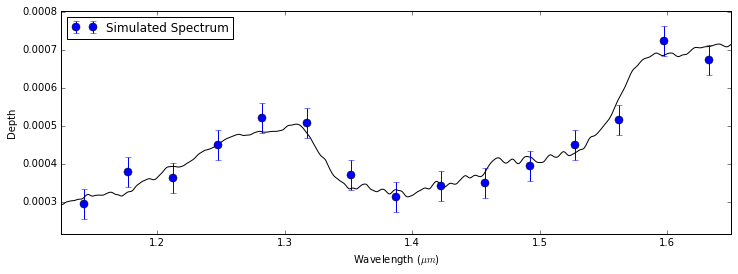

In [25]:
specfile   = exo_dict['planet']['exopath']
grism      = inst_dict['configuration']['instrument']['disperser']
nchan      = exo_dict['observation']['nchan']
hst.plot_PlanSpec(specfile, grism, deptherr, nchan, smooth=20)

#### Compare simulation to published results

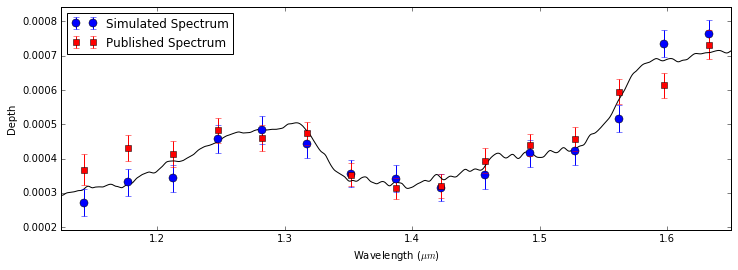

In [26]:
import cPickle as pickle
handle  = open('./PHASE7_WFC3_IRAC_spectra.pic')
model   = pickle.load(handle)
hst.plot_PlanSpec(specfile, grism, deptherr, nchan, smooth=20)
plt.errorbar(model[0],model[1],model[2],fmt='rs', label='Published Spectrum')
plt.legend(loc='upper left')

In [27]:
print("Simulated uncertainty: %0.1f ppm" % (deptherr*1e6))
print("Mean published uncertainty: %0.1f +/- %0.1f ppm" % (np.mean(model[2][:15])*1e6,np.std(model[2][:15])*1e6))
print("Results are consistent at %0.1f sigma." % ((deptherr-np.mean(model[2][:15]))/np.std(model[2][:15])))

Simulated uncertainty: 39.7 ppm
Mean published uncertainty: 36.5 +/- 3.5 ppm
Results are consistent at 0.9 sigma.


## Compute earliest and latest possible start times for given start window size

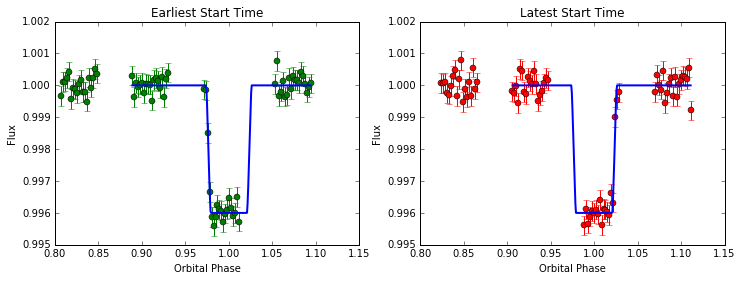

In [28]:
numorbits = exo_dict['observation']['norbits']
depth     = exo_dict['planet']['depth']
inc       = exo_dict['planet']['i']
aRs       = exo_dict['planet']['ars']
period    = exo_dict['planet']['period']
#duration = exo_dict['observation']['trdur']/86400. # Duration in days
tunc      = 10                                      # +/- start time uncertainty in minutes
minphase, maxphase = hst.calc_StartWindow(rms, ptsOrbit, numorbits, depth, inc, aRs, period, tunc)

In [29]:
print("Start observations between orbital phases: %0.4f - %0.4f" % (minphase, maxphase))

Start observations between orbital phases: 0.8071 - 0.8241


### ToDo List:
    
    Add functionality for STIS G430 and STIS G750 grisms
    Compute wavelength-dependent uncertainties for STIS
    Develop web interface (using PandExo) for end users
    Add additional calculation methods (currently scaling flux/variance from actual observations)